In [1]:
import os
from github import Github
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.pyplot as plt


#create an empty graph
G = nx.Graph()

In [2]:
# create nodes and edges between users and repositories
with open('dataset/users.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # transform the string of repositories into an array of strings
        row[2:4] = [x.replace(' ', '').replace('[', '').replace(']', '').replace('\'', '').replace('"', '').split(',') for x in row[2:4]]
        # Add the user node to graph with blue color
        G.add_node(row[0], name=row[1], repos=row[2], commits= row[3], color='#F8A643')

In [3]:
#create nodes and edges bewtween repositories and languages
with open('dataset/repos.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # transform the string of languages into an array of strings
        row[2], row[5], row[6] = tuple(x.replace(' ', '').replace('[', '').replace(']', '').replace('\'', '').replace('"', '').split(',') for x in (row[2], row[5], row [6]))
        
        G.add_node(row[0], name=row[1], topics=row[2], n_star=row[3], n_fork=row[4], languages=row[5], p_lang=row[6], color='#5D7EF5')

In [4]:
# Open the CSV file and read the data for languages
with open('dataset/languages.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # Add the language node to graph with green color
        G.add_node(row[0], language=row[1], color='#30FBD0')




In [5]:
#create edges between users, repositories and languages
for node in list(G.nodes):
    # if it's a user node
    if len(node) >= 1:
        if node[0] == "u":
            # for each repository in the user's list of repositories
            for repo in G.nodes[node]['repos']:
                # add an edge between the user and the repository
                G.add_edge(node, repo)
        if node[0] == "r":
            # for each language in the repository's list of languages
            for lang in G.nodes[node]['languages']:
                # add an edge between the repository and the language
                G.add_edge(node, lang)     

nx.info(G)

/var/folders/w2/jn05b8cd0kj32r1y2sywf38w0000gn/T/ipykernel_2033/4017047192.py:16: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 1499 nodes and 2369 edges'

In [6]:
# create a subgraph with only 'repository' and 'user' nodes
subgraph_nodes = [n for n in G.nodes if n.startswith(('u', 'r'))]
# create edges between users and repositories
user_repo_edges = [(u, v) for (v, u) in G.edges if u.startswith('u_') and v.startswith('r_')]
subgraph_ru = G.subgraph(subgraph_nodes)

In [7]:
# crea un sottografo con i nodi utente
user_nodes = [n for n in G.nodes if n.startswith("u")]
subgraph = G.subgraph(user_nodes).copy()

# aggiungi gli archi tra utenti che hanno contribuito alla stessa repository
for repo_node in subgraph_ru.nodes:
    # se il nodo corrente è una repository
    if repo_node.startswith("r"):
        # crea un insieme di utenti che hanno contribuito alla repository corrente
        repo_users = set(subgraph_ru.neighbors(repo_node)).intersection(user_nodes)
        # crea gli archi tra le coppie di utenti che hanno contribuito alla stessa repository
        subgraph.add_edges_from(combinations(repo_users,2))

nx.info(subgraph)

/var/folders/w2/jn05b8cd0kj32r1y2sywf38w0000gn/T/ipykernel_2033/420969897.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(subgraph)


'Graph with 271 nodes and 284 edges'

In [8]:
#calculate the betweenness centrality of all user node
betweenness = nx.betweenness_centrality(subgraph, normalized=True)

#calculate the betweenness centrality of languages nodes
lang_btc = {k: v for k, v in betweenness.items() if k.startswith('u_')}

#print the betweenness centrality of firts 5 languages in descendig order
for node, centrality in sorted(lang_btc.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("Node", node, "has betweenness centrality", centrality)


Node u_238 has betweenness centrality 0.01396117306897976
Node u_148 has betweenness centrality 0.013382899628252789
Node u_237 has betweenness centrality 0.011455321492496213
Node u_185 has betweenness centrality 0.010298774611042269
Node u_235 has betweenness centrality 0.008921933085501859
Node u_64 has betweenness centrality 0.0056725870852264906
Node u_67 has betweenness centrality 0.005507366102161641
Node u_157 has betweenness centrality 0.003469640644361834
Node u_172 has betweenness centrality 0.0023681674239295057
Node u_207 has betweenness centrality 0.001211620542475561


{'u_238': Text(0.2591105017665563, 0.051609789224382065, 'u_238'),
 'u_148': Text(-0.06539596615534735, 0.09290623877815128, 'u_148'),
 'u_237': Text(0.5579577223856798, -0.05133601278720068, 'u_237'),
 'u_185': Text(-0.304385612869091, -0.04543459717280317, 'u_185'),
 'u_235': Text(-0.5327446983674222, -0.2711195841736067, 'u_235'),
 'u_64': Text(-0.3237336718597558, 0.2530436021386285, 'u_64'),
 'u_67': Text(0.7317065843619093, -0.25031527900323314, 'u_67'),
 'u_157': Text(0.8546769201503408, -0.11436686748537699, 'u_157'),
 'u_172': Text(0.8049699059167729, 0.06150975862853909, 'u_172'),
 'u_207': Text(-0.7460970653645193, -0.48202082300573645, 'u_207')}

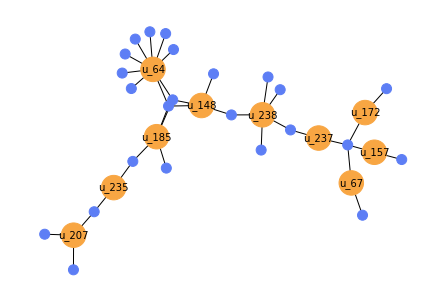

In [9]:
# Draw the graph containing only the top 5 user with neighbours based on degree centrality
languages_subgraph = nx.Graph()
for node in sorted(lang_btc, key=lang_btc.get, reverse=True)[:10]:
    languages_subgraph.add_node(node, color = G.nodes[node]['color'])
    for neighbour in G.neighbors(node):
        if neighbour[0] == "u":
            languages_subgraph.add_node(neighbour, color = G.nodes[neighbour]['color'])
        else:
            languages_subgraph.add_node(neighbour, color = G.nodes[neighbour]['color'])
        languages_subgraph.add_edge(node, neighbour)

pos = nx.kamada_kawai_layout(languages_subgraph)
node_sizes = []
for node in languages_subgraph.nodes:
    if node.startswith('u_'):
        node_sizes.append(600)
    elif node.startswith('u_'):
        node_sizes.append(100)
    else:
        node_sizes.append(100)
nx.draw(languages_subgraph, pos, node_size=node_sizes, node_color=[languages_subgraph.nodes[node]['color'] for node in languages_subgraph.nodes])
labels = {node: node for node in languages_subgraph.nodes if node.startswith('u_')}
nx.draw_networkx_labels(languages_subgraph, pos, labels, font_size=10)

#rapportare il numero di commit in base alle repository in cui partecipa un utente

k-mean clustering


Il calcolo del k-means clustering su questo sottografo potrebbe aiutare a identificare le comunità di utenti che utilizzano gli stessi linguaggi di programmazione o collaborano su progetti simili. In particolare, il clustering potrebbe rivelare se ci sono gruppi di utenti che collaborano principalmente su progetti legati a un determinato linguaggio di programmazione o se ci sono gruppi di utenti che collaborano su progetti che coprono diversi linguaggi di programmazione. Questa informazione potrebbe essere utile per scopi come il recruiting di sviluppatori per un progetto specifico o l'identificazione di trend nella comunità di sviluppatori.

In [11]:
subgraphs = {}
for node in G.nodes:
    if node[0] == "r":
        for language in G.nodes[node]['languages']:
            if language not in subgraphs:
                subgraphs[language] = nx.Graph()
            subgraphs[language].add_node(node)
            for neighbor in G.neighbors(node):
                subgraphs[language].add_node(neighbor)
                subgraphs[language].add_edge(node, neighbor)

IndexError: string index out of range

In [12]:
adj_matrix = nx.adjacency_matrix(subgraph)

# Calcolo del k-means clustering
k = 3  # Numero di cluster desiderato
kmeans = KMeans(n_clusters=k, random_state=0).fit(adj_matrix)

# Visualizzazione dei risultati
for i in range(k):
    nodes = np.where(kmeans.labels_ == i)[0]
    print("Cluster", i, ":", nodes)

Cluster 0 : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  38  39
  40  41  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  93  94  95
  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 125 126 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 144 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 178 179 181 182 183 184 185 186 187 188 189 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 214 215 216 217 218 219 220 221 223 224 225 226 227 228 229 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 260 261 26

/var/folders/w2/jn05b8cd0kj32r1y2sywf38w0000gn/T/ipykernel_2033/1643136901.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(subgraph)


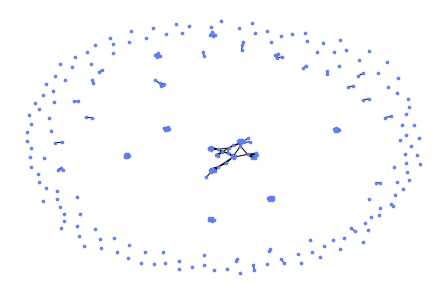

In [13]:
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_size=7,node_color='#5D7EF5')

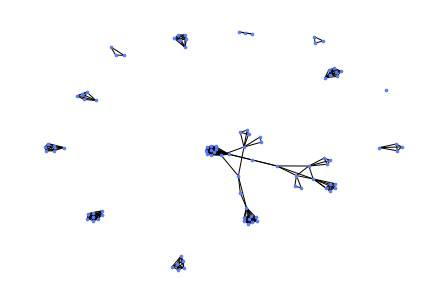

In [14]:
# Create a graph containing only the nodes with at least two edges
graph_for_clustering_removed = nx.Graph()
for node in subgraph.nodes:
    if subgraph.degree(node) > 1:
        graph_for_clustering_removed.add_node(node, name=subgraph.nodes[node]['name'], color=subgraph.nodes[node]['color'])
        for neighbor in subgraph.neighbors(node):
            if subgraph.degree(neighbor) > 1:
                graph_for_clustering_removed.add_node(neighbor, name=subgraph.nodes[neighbor]['name'], color=subgraph.nodes[neighbor]['color'])
                graph_for_clustering_removed.add_edge(node, neighbor)

pos = nx.spring_layout(graph_for_clustering_removed, k=0.15)
nx.draw(graph_for_clustering_removed, pos, node_size=7,node_color='#5D7EF5')

In [34]:
def same_langs(repo1, repo2):
    langs1 = set(G.nodes[repo1]['languages'])
    langs2 = set(G.nodes[repo2]['languages'])
    return langs1 == langs2

repos = [r for r in G.nodes if r.startswith('r_')]
structural_equivalence = nx.equivalence_classes(repos, same_langs)

# Print the number of structural equivalence classes
print("\nNumber of structural equivalence classes:", structural_equivalence)

# Ottieni le combinazioni di linguaggi utilizzati insieme
lang_combinations = {}
for equiv_class in structural_equivalence:
    lang_set = set()
    for repo in equiv_class:
        lang_set.update(set(G.nodes[repo]['languages']))
    for combo in combinations(lang_set, 2):
        lang_combinations[combo] = lang_combinations.get(combo, 0) + 1

#creazione del grafo
G_langs = nx.Graph()

top_combinations = sorted(lang_combinations.items(), key=lambda x: x[1], reverse=True)[:90]
print("\nTop 5 language combinations:")
for combo, count in top_combinations:
    print(combo, count)

#creazione del grafo
G_langs = nx.Graph()
for combo, count in top_combinations:
    lang1, lang2 = combo
    G_langs.add_edge(lang1, lang2, weight=count)


Number of structural equivalence classes: {frozenset({'r_43'}), frozenset({'r_325', 'r_406'}), frozenset({'r_950'}), frozenset({'r_191', 'r_843', 'r_330', 'r_851', 'r_281'}), frozenset({'r_774'}), frozenset({'r_637'}), frozenset({'r_299'}), frozenset({'r_1064'}), frozenset({'r_168', 'r_373', 'r_976'}), frozenset({'r_300'}), frozenset({'r_766'}), frozenset({'r_700', 'r_4', 'r_463', 'r_411', 'r_647', 'r_270', 'r_36', 'r_575', 'r_1107'}), frozenset({'r_668'}), frozenset({'r_806'}), frozenset({'r_305'}), frozenset({'r_772', 'r_164', 'r_885', 'r_146', 'r_628', 'r_222', 'r_243', 'r_965', 'r_1009', 'r_46', 'r_375', 'r_489', 'r_648', 'r_1122', 'r_382', 'r_1091', 'r_706', 'r_128', 'r_113', 'r_961', 'r_23', 'r_21', 'r_670', 'r_333', 'r_673', 'r_410', 'r_852', 'r_54', 'r_727', 'r_1103', 'r_971', 'r_482', 'r_1024', 'r_1066', 'r_369', 'r_915', 'r_1033', 'r_1032', 'r_53', 'r_1095', 'r_1115'}), frozenset({'r_606'}), frozenset({'r_15', 'r_276', 'r_396', 'r_887', 'r_760'}), frozenset({'r_154'}), froze

In [35]:
cliques = list(nx.find_cliques(G_langs))

print("Number of cliques:", len(cliques))
print(cliques)

Number of cliques: 14
[['l_4', 'l_3', 'l_1'], ['l_4', 'l_26'], ['l_4', 'l_6', 'l_28', 'l_10', 'l_0'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_30', 'l_10'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_30', 'l_18'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_0', 'l_12'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_0', 'l_1', 'l_2', 'l_14'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_0', 'l_1', 'l_10', 'l_8'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_0', 'l_1', 'l_10', 'l_14'], ['l_4', 'l_6', 'l_9', 'l_11', 'l_0', 'l_18', 'l_2'], ['l_4', 'l_6', 'l_9', 'l_13', 'l_1'], ['l_4', 'l_6', 'l_7', 'l_11'], ['l_4', 'l_38', 'l_0'], ['l_15', 'l_2', 'l_11']]


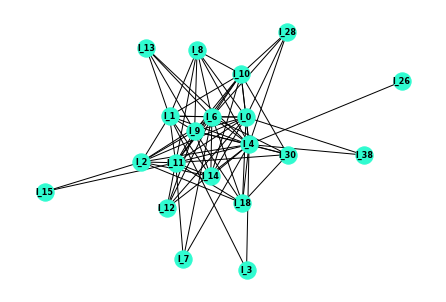

In [36]:
#draw the graph of the cliques in G_langs
G_langs_cliques = nx.Graph()

for clique in cliques:
    for node in clique:
        G_langs_cliques.add_node(node)
    for edge in combinations(clique, 2):
        G_langs_cliques.add_edge(edge[0], edge[1])

pos = nx.spring_layout(G_langs_cliques)
nx.draw(G_langs_cliques, pos, with_labels=True, font_size=8, font_weight='bold', node_color='#30FBD0')


Number of structural equivalence classes: {frozenset({'r_43'}), frozenset({'r_325', 'r_406'}), frozenset({'r_950'}), frozenset({'r_191', 'r_843', 'r_330', 'r_851', 'r_281'}), frozenset({'r_774'}), frozenset({'r_637'}), frozenset({'r_299'}), frozenset({'r_1064'}), frozenset({'r_168', 'r_373', 'r_976'}), frozenset({'r_300'}), frozenset({'r_766'}), frozenset({'r_700', 'r_4', 'r_463', 'r_411', 'r_647', 'r_270', 'r_36', 'r_575', 'r_1107'}), frozenset({'r_668'}), frozenset({'r_806'}), frozenset({'r_305'}), frozenset({'r_772', 'r_164', 'r_885', 'r_146', 'r_628', 'r_222', 'r_243', 'r_965', 'r_1009', 'r_46', 'r_375', 'r_489', 'r_648', 'r_1122', 'r_382', 'r_1091', 'r_706', 'r_128', 'r_113', 'r_961', 'r_23', 'r_21', 'r_670', 'r_333', 'r_673', 'r_410', 'r_852', 'r_54', 'r_727', 'r_1103', 'r_971', 'r_482', 'r_1024', 'r_1066', 'r_369', 'r_915', 'r_1033', 'r_1032', 'r_53', 'r_1095', 'r_1115'}), frozenset({'r_606'}), frozenset({'r_15', 'r_276', 'r_396', 'r_887', 'r_760'}), frozenset({'r_154'}), froze

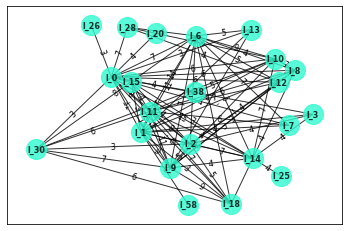

In [37]:
#calculare structural equivalence classes
def same_langs(repo1, repo2):
    langs1 = set(G.nodes[repo1]['languages'])
    langs2 = set(G.nodes[repo2]['languages'])
    return langs1 == langs2

repos = [r for r in G.nodes if r.startswith('r_')]
structural_equivalence = nx.equivalence_classes(repos, same_langs)

# Print the number of structural equivalence classes
print("\nNumber of structural equivalence classes:", structural_equivalence)

# Ottieni le combinazioni di linguaggi utilizzati insieme 
lang_combinations = {}
for equiv_class in structural_equivalence:
    lang_set = set()
    for repo in equiv_class:
        lang_set.update(set(G.nodes[repo]['languages']))
    for combo in combinations(lang_set, 2):
        if 'l_4' not in combo:
            lang_combinations[combo] = lang_combinations.get(combo, 0) + 1

# Stampa le 5 combinazioni di linguaggi più utilizzate
top_combinations = sorted(lang_combinations.items(), key=lambda x: x[1], reverse=True)[:90]
print("\nTop 5 language combinations:")
for combo, count in top_combinations:
    print(combo, count)

#creazione del grafo
G_langs1 = nx.Graph()
for combo, count in top_combinations:
    lang1, lang2 = combo
    if lang1 != 'l_4' and lang2 != 'l_4':
        G_langs1.add_edge(lang1, lang2, weight=count)


# layout e visualizzazione del grafo
pos = nx.spring_layout(G_langs1, k=0.90, iterations=1)

edge_weights = nx.get_edge_attributes(G_langs1, 'weight')
nx.draw_networkx_edge_labels(G_langs1, pos, edge_labels=edge_weights, font_size=8)
nx.draw_networkx(G_langs1, pos, with_labels=True, node_size=400, node_color='#30FBD0', width=1, alpha=0.8, font_size=8, font_color='black', font_weight='bold')

In [38]:
cliques = list(nx.find_cliques(G_langs1))

print("Number of cliques:", len(cliques))
print(cliques)

Number of cliques: 18
[['l_25', 'l_14'], ['l_0', 'l_20'], ['l_0', 'l_26'], ['l_0', 'l_6', 'l_28', 'l_12'], ['l_0', 'l_6', 'l_28', 'l_10'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_2', 'l_30', 'l_18'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_2', 'l_12'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_2', 'l_1', 'l_8', 'l_18'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_2', 'l_1', 'l_14'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_10', 'l_30'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_10', 'l_1', 'l_8'], ['l_0', 'l_6', 'l_9', 'l_11', 'l_10', 'l_1', 'l_14'], ['l_0', 'l_6', 'l_9', 'l_13', 'l_1'], ['l_0', 'l_6', 'l_7', 'l_1', 'l_11'], ['l_0', 'l_38'], ['l_0', 'l_3', 'l_2', 'l_1', 'l_14'], ['l_58', 'l_1'], ['l_15', 'l_9', 'l_2', 'l_1', 'l_11', 'l_14']]


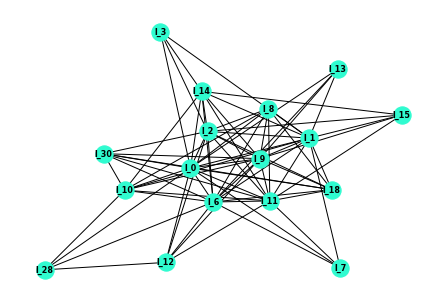

In [45]:
G_langs_cliques = nx.Graph()

for clique in cliques:
    if len(clique) > 2:
        for node in clique:
            G_langs_cliques.add_node(node)
        for edge in combinations(clique, 2):
            G_langs_cliques.add_edge(edge[0], edge[1])

pos = nx.spring_layout(G_langs_cliques)
nx.draw(G_langs_cliques, pos, with_labels=True, font_size=8, font_weight='bold', node_color='#30FBD0')

#draw the cliques graph with only node degree > 1

In [29]:
components = list(nx.connected_components(G))

print(len(list(components)))

#print the list of each node in each component
for i, component in enumerate(components):
    print(f"Component {i+1} has {len(component)} nodes")
    for node in component:
        print(node)
    print()

0
